`RandomList` is a class that helps to select an entry from a weighted random list. It is used to select Gaussian clusters from Gaussian mixture.

In [39]:
from typing import TypeVar, Generic, List, Final

T = TypeVar('T')


class WeightedEntry(Generic[T]):

    def __init__(self, weight: float, data: T):
        self.weight: Final = weight
        self.data: Final = data


class RandomList(Generic[T]):

    def __init__(self):
        self.list: List[WeightedEntry[T]] = []
        self.sum_weight = 0

    def add_entry(self, weight: float, obj: T):
        if weight <= 0:
            raise AssertionError("invalid weight: " + str(weight))
        self.list.append(WeightedEntry(weight, obj))
        self.sum_weight += weight

    def get_random_entry(self, rand_number: float):
        if rand_number < 0 or rand_number > 1 or len(self.list) == 0 or self.sum_weight <= 0:
            raise AssertionError("invalid list")
        rand_number *= self.sum_weight
        for entry in self.list:
            rand_number -= entry.weight
            if rand_number < 0:
                return entry.data
        raise AssertionError("failed to find entry")


`GaussianVariable` represents one Gaussian cluster. It receievs mean and A matrix, where A times transpose of A equals to the covariance.
- `sample_data`: function to give a random vector that follows the distribution represented by this cluster
- `get_density`: get the value of density function at one location

`GaussianMixture` represents one Gaussian mixture. It is a weighted random list of Gaussian clusters.
- `get_random_data` gives an array of sample data generated according to the distribution of this mixture
- `get_density` provides the value of density function represented by this mixture

In [111]:
import numpy as np
import math


class GaussianVariable(object):

    def __init__(self, n: int, mean: np.ndarray, a: np.ndarray):
        self.n = n
        self.mean = mean
        self.a = a
        if mean.shape != (n,):
            raise AssertionError("mean dimension mismatch")
        if a.shape != (n, n):
            raise AssertionError("cov dimension mismatch")

    def sample_data(self):
        iid = np.random.standard_normal((self.n,))
        return self.mean + np.matmul(self.a, iid)

    def get_density(self, data: np.ndarray):
        c = np.matmul(self.a, np.transpose(self.a))
        x = data - self.mean
        coef = math.pow(2 * math.pi * np.linalg.det(c), -1 / 2)
        expm = -np.matmul(np.matmul(x, np.linalg.inv(c)), np.transpose(x)) / 2
        return coef * math.exp(expm)


class GaussianMixture(RandomList[GaussianVariable]):

    def __init__(self, n: int):
        super().__init__()
        self.n = n

    def add_gaussian(self, weight: float, mean: np.ndarray, a: np.ndarray):
        self.add_entry(weight, GaussianVariable(self.n, mean, a))

    def get_random_data(self, size: int, seed: int = 0):
        np.random.seed(seed)
        choice = np.random.random((size,))
        return np.asarray([self.get_random_entry(val).sample_data() for val in choice])

    def get_density(self, data: np.ndarray):
        chance = 0
        for entry in self.list:
            chance += entry.weight * entry.data.get_density(data)
        return chance


### Problem 1
`a_from_eigen_angle` generates the A matrix from eigen values and angle of eigen vectors
Then I construct the mixtures, collect samples, and plot them. Blue dots are the class 0 points, and orange dots are the class 1 points.

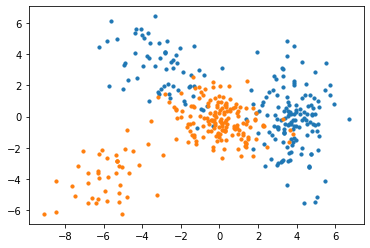

In [132]:
import math
import numpy as np
import matplotlib.pyplot as plt

def a_from_eigen_angle(eig_1, eig_2, theta):
    eig_vector = np.transpose(np.array([[math.cos(theta), math.sin(theta)], 
            [-math.sin(theta), math.cos(theta)]]))
    eig_value = np.diag([math.sqrt(eig_1), math.sqrt(eig_2)])
    return np.matmul(eig_vector, eig_value)

mixture_0 = GaussianMixture(2)
mixture_0.add_gaussian(2 / 3, np.array([4, 0]), 
        a_from_eigen_angle(1, 4, 0))
mixture_0.add_gaussian(1 / 3, np.array([-3, 3]), 
        a_from_eigen_angle(1, 4, math.pi / 4))
sample_0 = mixture_0.get_random_data(200, 0)
plt.scatter(sample_0[:, 0], sample_0[:, 1],s=10)


mixture_1 = GaussianMixture(2)
mixture_1.add_gaussian(3 / 4, np.array([0, 0]), 
        a_from_eigen_angle(1, 2, math.pi / 3))
mixture_1.add_gaussian(1 / 4, np.array([-6, -4]), 
        a_from_eigen_angle(2, 1, math.pi / 4))
sample_1 = mixture_1.get_random_data(200, 0)
plt.scatter(sample_1[:, 0], sample_1[:, 1],s=10)


### Problem 2
Here I create a 500x500 mesh grid, and fill with the difference of PDF of two mixtures. Positive value means it represents areas that will be classified as class 1 by MAP. Negative value means it represents areas that will be classified as class 0 by MAP.

In [121]:
gran = 500
X, Y = np.meshgrid(np.linspace(-10, 10, gran), np.linspace(-10, 10, gran))
Z = np.zeros((gran,gran))
for i in range(gran):
    for j in range(gran):
        Z[i,j] = mixture_1.get_density(np.array([X[i,j],Y[i,j]]))-mixture_0.get_density(np.array([X[i,j],Y[i,j]]))



Then I classify the sample data based on MAP. 

Blue region is the region classified as class 0 by MAP. 

Orange region is the region classified as class 1 by MAP. 

White dots are the sample data points that are classified correctly. 

Blue x's are the sample data points that are from class 0 but classified as class 1.

Orange x's are the sample data points that are from class 1 but classified as class 0.

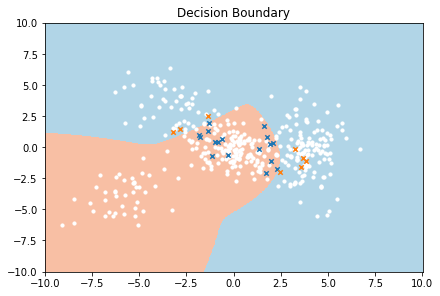

In [125]:
W = np.sign(Z)*0.3
fig, axs = plt.subplots(1, 1, layout='constrained')
pc = axs.pcolormesh(X, Y, W, vmin=-1, vmax=1, cmap='RdBu_r')
axs.set_title('Decision Boundary')

c0a = [mixture_0.get_density(sample_0[i])>mixture_1.get_density(sample_0[i]) for i in range(200)]
c0b = [not c0a[i] for i in range(200)]

c1a = [mixture_1.get_density(sample_1[i])>mixture_0.get_density(sample_1[i]) for i in range(200)]
c1b = [not c1a[i] for i in range(200)]
plt.scatter(sample_0[c0a, 0], sample_0[c0a, 1], s = 10, c='#ffffff',marker='o')
plt.scatter(sample_1[c1a, 0], sample_1[c1a, 1], s = 10,c='#ffffff',marker='o')
plt.scatter(sample_0[c0b, 0], sample_0[c0b, 1], s = 20, c='#1f77b4',marker='x')
plt.scatter(sample_1[c1b, 0], sample_1[c1b, 1], s = 20,c='#ff7f0e',marker='x')

### Problem 3
Here I collect 100k sample data to calculate the rate of misclassification.

In [133]:
n = 100000
err_0 = 0
err_1 = 0
map_sample_0 = mixture_0.get_random_data(n, 0)
map_sample_1 = mixture_1.get_random_data(n, 0)
for i in range(n):
    if mixture_1.get_density(map_sample_0[i]) > mixture_0.get_density(map_sample_0[i]):
        err_0 += 1
    if mixture_0.get_density(map_sample_1[i]) > mixture_1.get_density(map_sample_1[i]):
        err_1 += 1
print(err_0, err_1)

8414 5879


Verify that `n` is large enough

In [154]:
print(10*n/err_0)
print(10*n/err_1)

118.84953648680771
170.09695526450076


Thus, we can know that the error probabilities are 8.41% and 5.88% respectively.

### Problem 4

#### Part A

I process data in bulk.
- sample: n by 2 matrix, each row is one data point
- label: 1 by n vector, each element is one label
- data = phi(sample): 10 by n matrix each column is one data point
- w: 1 by 10 vector

matrix multiplying diagnal matrix is the same as matrix multiplying a list representing the diagnal in numpy, so we can use this approach to avoid creating large diagnal matrix.

p(data|w) = yhat^y * (1-yhat)^(1-y)=yhat * y + (1-yhat) * (1-y), for easy calculation

In [270]:
def phi(x: np.ndarray, y:np.ndarray):
    return np.array([x*0+1, x, y, x*x, y*y, x*y, x**3, x*x*y, x*y*y, y**3])


def sig(x: np.ndarray):
    return 1/(1+np.exp(-x))


def regress(data_0: np.ndarray, data_1: np.ndarray, n: int, lbd: float):
    sample = np.concatenate((data_0[0:n, :], data_1[0:n, :]))
    data = phi(sample[:,0],sample[:,1])
    label = np.concatenate((np.zeros((n,)), np.ones((n,))))
    w = np.zeros((10,))
    dw = np.ones((10,))
    cost = []
    while np.linalg.norm(dw)>1e-3:
        yhat = sig(np.matmul(w, data))
        H = np.matmul(data*(yhat*(1-yhat)),np.transpose(data)) + lbd*np.identity(10)
        x = np.matmul(data, yhat-label)+lbd*w
        dw = np.matmul(np.linalg.inv(H),x)
        w -= dw
        cf = 0
        for i in range(n*2):
            cf -= np.log(yhat[i]) if label[i] == 1 else np.log(1-yhat[i])
        cost.append(cf/n)
    return {"w":w,"cost":cost,"n":n,"lbd":lbd}



Text(0, 0.5, 'Cost Function Value (Without Regularization Term)')

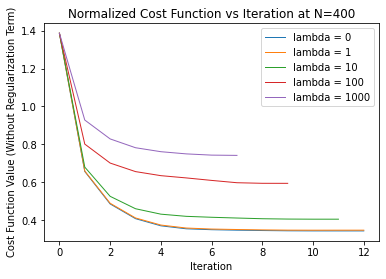

In [269]:
param_list = [0,1,10,100,1000]
reg_list = [regress(map_sample_0, map_sample_1,200,lbd) for lbd in param_list]

fig, ax = plt.subplots()
lines = []
for reg in reg_list:
    line, = ax.plot(reg["cost"],linewidth=1, label = 'lambda = '+str(reg["lbd"]))
    lines.append(line)
ax.legend(handles = lines)
ax.set_title("Normalized Cost Function vs Iteration at N=400")
ax.set_xlabel("Iteration")
ax.set_ylabel("Cost Function Value (Without Regularization Term)")

Text(0, 0.5, 'Normalized Cost Function Value')

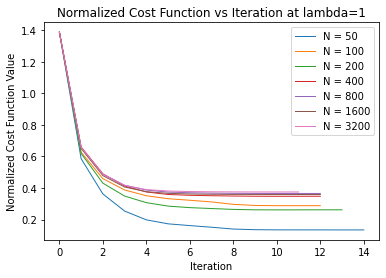

In [275]:
param_list = [25,50,100,200,400,800,1600]
reg_list = [regress(map_sample_0, map_sample_1,num,1) for num in param_list]

fig, ax = plt.subplots()
lines = []
for reg in reg_list:
    line, = ax.plot(reg["cost"],linewidth=1, label = 'N = '+str(reg["n"]*2))
    lines.append(line)
ax.legend(handles = lines)
ax.set_title("Normalized Cost Function vs Iteration at lambda=1")
ax.set_xlabel("Iteration")
ax.set_ylabel("Normalized Cost Function Value")

#### Part B

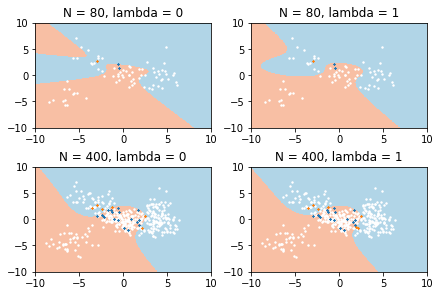

In [339]:
def plot_lr(reg,axs,n,title):
    samp_0 = map_sample_0[0:n,:]
    samp_1 = map_sample_1[0:n,:]
    w0 = reg["w"]
    ZL = np.zeros((gran,gran))
    for i in range(gran):
        for j in range(gran):
            ZL[i,j] = np.dot(w0,phi(X[i,j],Y[i,j]))
    WL = np.sign(ZL)*0.3
    pc = axs.pcolormesh(X, Y, WL, vmin=-1, vmax=1, cmap='RdBu_r')
    axs.set_title(title)

    c0a = [sig(np.dot(w0,phi(samp_0[i,0],samp_0[i,1])))<0.5 for i in range(n)]
    c0b = [not c0a[i] for i in range(n)]

    c1a = [sig(np.dot(w0,phi(samp_1[i,0],samp_1[i,1])))>0.5 for i in range(n)]
    c1b = [not c1a[i] for i in range(n)]
    axs.scatter(samp_0[c0a, 0], samp_0[c0a, 1], s = 2, c='#ffffff',marker='o')
    axs.scatter(samp_1[c1a, 0], samp_1[c1a, 1], s = 2,c='#ffffff',marker='o')
    axs.scatter(samp_0[c0b, 0], samp_0[c0b, 1], s = 2, c='#1f77b4',marker='x')
    axs.scatter(samp_1[c1b, 0], samp_1[c1b, 1], s = 2,c='#ff7f0e',marker='x')

fig, axs = plt.subplots(2, 2, layout='constrained')
plot_lr(regress(map_sample_0, map_sample_1,40,0),axs[0,0],40,"N = 80, lambda = 0")
plot_lr(regress(map_sample_0, map_sample_1,40,1),axs[0,1],40,"N = 80, lambda = 1")
plot_lr(regress(map_sample_0, map_sample_1,200,0),axs[1,0],200,"N = 400, lambda = 0")
plot_lr(regress(map_sample_0, map_sample_1,200,1),axs[1,1],200,"N = 400, lambda = 1")

#### Part C

generate new samples so I have different traning and testing sample

In [340]:
n = 100000
train_sample_0 = mixture_0.get_random_data(n, 0)
train_sample_1 = mixture_1.get_random_data(n, 0)
reg = regress(train_sample_0, train_sample_1, n, 1)



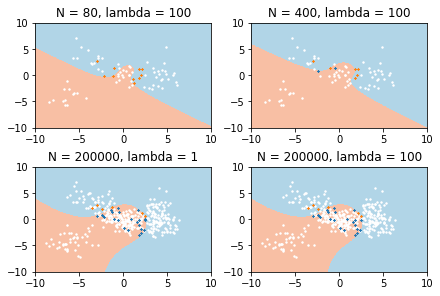

In [349]:

fig, axs = plt.subplots(2, 2, layout='constrained')
plot_lr(regress(train_sample_0, train_sample_1,40,100),axs[0,0],40,"N = 80, lambda = 100")
plot_lr(regress(train_sample_0, train_sample_1,200,100),axs[0,1],40,"N = 400, lambda = 100")
plot_lr(regress(train_sample_0, train_sample_1,100000,1),axs[1,0],200,"N = 200000, lambda = 1")
plot_lr(regress(train_sample_0, train_sample_1,100000,100),axs[1,1],200,"N = 200000, lambda = 100")

In [350]:
def test(reg):
    n = 100000
    err_0 = 0
    err_1 = 0
    w0 = reg["w"]
    for i in range(n):
        if sig(np.dot(w0,phi(map_sample_0[i,0],map_sample_0[i,1])))>0.5:
            err_0 += 1
        if sig(np.dot(w0,phi(map_sample_1[i,0],map_sample_1[i,1])))<0.5:
            err_1 += 1
    print(err_0/n, err_1/n)

test(regress(train_sample_0, train_sample_1,40,0))
test(regress(train_sample_0, train_sample_1,40,1))
test(regress(train_sample_0, train_sample_1,40,100))
test(regress(train_sample_0, train_sample_1,200,0))
test(regress(train_sample_0, train_sample_1,200,1))
test(regress(train_sample_0, train_sample_1,200,100))
test(regress(train_sample_0, train_sample_1,100000,1))
test(regress(train_sample_0, train_sample_1,100000,100))

/var/folders/rn/dhzskl6j58ncs48jjhxm33gw0000gp/T/ipykernel_45036/2587346024.py:6: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-x))


0.12716 0.09986
0.08264 0.09852
0.02916 0.3409
0.08378 0.06924
0.08374 0.06963
0.06418 0.14783
0.09406 0.05086
0.09387 0.05096
0.09406 0.05086


#### Part D

0.0769 0.15603


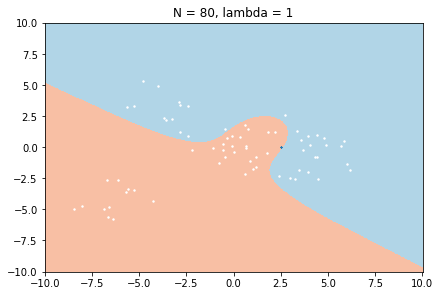

In [353]:

fig, axs = plt.subplots(1, 1, layout='constrained')
plot_lr(regress(train_sample_0, train_sample_1,30,0.1),axs,35,"N = 80, lambda = 1")
test(regress(train_sample_0, train_sample_1,30,0.1))